In [ ]:
# 高階網路結構分析：不同網路類型的 Motif 比較
# 使用多種數據集：蛋白質網路、化學分子網路、社交網路

import torch
import torch_geometric   # 圖形深度學習框架
from torch_geometric.datasets import TUDataset  # TUDataset 包含一系列用於圖形分類 (Graph Classification) 的圖形數據集
from torch_geometric.utils import to_networkx  # 數據格式轉換工具，將 PyG 的圖形數據格式轉換成 NetworkX 可以處理的格式。
import networkx as nx   # 處理和分析圖形結構的核心工具
import matplotlib.pyplot as plt
import numpy as np
# 圖例分組顯示
from matplotlib.patches import Patch

print(f"PyTorch version: {torch.__version__}")
print(f"PyG version: {torch_geometric.__version__}")
print(f"NetworkX version: {nx.__version__}")

PyTorch version: 2.1.2+cu121
PyG version: 2.6.1
NetworkX version: 3.2.1


## 1. 載入多種類型的網路數據集

我們將比較以下三種不同的網路類型：
- **PROTEINS**: 蛋白質交互網路（生物網路）- 節點代表蛋白質，邊代表交互作用
- **MUTAG**: 化學分子網路（分子結構）- 節點代表原子，邊代表化學鍵
- **IMDB-BINARY**: 電影合作網路（社交網路）- 節點代表演員，邊代表合作關係

每種網路類型都有不同的結構特性和 motif 分布特徵。

In [ ]:
# 載入不同類型的數據集
print("Loading datasets...")

# 生物網路
proteins_dataset = TUDataset(root='./data/PROTEINS', name='PROTEINS')

# 化學分子網路
mutag_dataset = TUDataset(root='./data/MUTAG', name='MUTAG')

# 社交網路
imdb_dataset = TUDataset(root='./data/IMDB-BINARY', name='IMDB-BINARY')

print(f"\n數據集統計:")
print(f"PROTEINS: {len(proteins_dataset)} graphs (蛋白質交互網路)")
print(f"MUTAG: {len(mutag_dataset)} graphs (化學分子結構)")
print(f"IMDB-BINARY: {len(imdb_dataset)} graphs (電影合作網路)")

# 選擇有代表性的圖（選擇中等大小的圖，避免太大或太小）
def select_representative_graph(dataset, target_nodes=30):
    """選擇節點數接近目標值的圖"""
    best_idx = 0
    best_diff = float('inf')
    for idx, data in enumerate(dataset):
        num_nodes = data.num_nodes
        # 確保圖的大小適中且有足夠的邊
        if 15 <= num_nodes <= 50:  # 限制範圍
            diff = abs(num_nodes - target_nodes)
            if diff < best_diff:
                best_diff = diff
                best_idx = idx
    return best_idx

# 選擇代表性的圖，確保目標節點數 (25 or 20)
# 確保選出的三個圖具有相似的圖形大小，這樣在進行 Motif 分布比較時才具有可比性，避免因圖形大小差異過大而導致偏差。
protein_idx = select_representative_graph(proteins_dataset, 25)
mutag_idx = select_representative_graph(mutag_dataset, 20)
imdb_idx = select_representative_graph(imdb_dataset, 25)

print(f"\n選擇的圖索引:")
print(f"PROTEINS: graph {protein_idx}")
print(f"MUTAG: graph {mutag_idx}")
print(f"IMDB: graph {imdb_idx}")

# 轉換為 NetworkX 圖
G_protein = to_networkx(proteins_dataset[protein_idx], to_undirected=True)
G_mutag = to_networkx(mutag_dataset[mutag_idx], to_undirected=True)
G_imdb = to_networkx(imdb_dataset[imdb_idx], to_undirected=True)

# 移除自環（確保圖的簡潔性）
graphs = {
    'PROTEINS': G_protein,
    'MUTAG': G_mutag,
    'IMDB': G_imdb
}

print(f"\n圖的基本信息:")
for name, G in graphs.items():
    G.remove_edges_from(nx.selfloop_edges(G))
    # 只保留最大連通分量（簡化分析）
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()
        graphs[name] = G
    print(f"{name}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Loading datasets...

數據集統計:
PROTEINS: 1113 graphs (蛋白質交互網路)
MUTAG: 188 graphs (化學分子結構)
IMDB-BINARY: 1000 graphs (電影合作網路)

選擇的圖索引:
PROTEINS: graph 44
MUTAG: graph 7
IMDB: graph 296

圖的基本信息:
PROTEINS: 25 nodes, 51 edges
MUTAG: 20 nodes, 22 edges
IMDB: 25 nodes, 91 edges

選擇的圖索引:
PROTEINS: graph 44
MUTAG: graph 7
IMDB: graph 296

圖的基本信息:
PROTEINS: 25 nodes, 51 edges
MUTAG: 20 nodes, 22 edges
IMDB: 25 nodes, 91 edges


從圖的基本信息可大致看出，實際節點數皆在20~25個nodes，而在此次三個資料集的邊數大致可看出，MUTAG相對稀疏，PROTEINS中等稠密，IMDB是這三組最稠密的。

## 2. Motif 計算函數

我們將計算以下常見的網路 motif 結構：

- **Triangle (三角形)**: 三個節點兩兩相連
- **Wedge (楔形)**: 兩個節點共享一個鄰居但彼此不相連  
- **4-Clique (K4)**: 四個節點完全連接
- **4-Star (星型)**: 中心節點連接三個葉節點

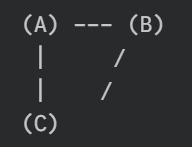
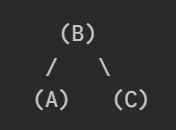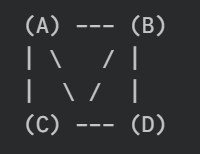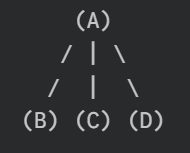

In [ ]:
from itertools import combinations

def count_triangles(G):
    """計算三角形數量（3-clique）"""
    return sum(nx.triangles(G).values()) // 3

def count_wedges(G):
    """
    計算楔形（Wedge）數量
    結構：兩個節點共享一個鄰居，但彼此不相連（形如 V 或 ∧）
    """
    count = 0
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        degree = len(neighbors)
        if degree >= 2:
            # 計算有多少對鄰居不相連
            for n1, n2 in combinations(neighbors, 2):
                if not G.has_edge(n1, n2):
                    count += 1
    return count

def count_4_cliques(G):
    """計算 4-clique (完全圖 K4) 數量"""
    cliques = list(nx.enumerate_all_cliques(G))
    return sum(1 for c in cliques if len(c) == 4)

def count_4_stars(G):
    """
    計算 4-star (星型結構) 數量
    結構：一個中心節點連接3個葉節點，葉節點之間無連接
    """
    count = 0
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        degree = len(neighbors)

        if degree >= 3:
            # 檢查是否有3個鄰居之間完全不相連（形成星型）
            for three_neighbors in combinations(neighbors, 3):
                n1, n2, n3 = three_neighbors
                if not G.has_edge(n1, n2) and not G.has_edge(n2, n3) and not G.has_edge(n1, n3):
                    count += 1
    return count

def calculate_all_motifs(G):
    """計算所有 motif 並返回結果字典"""
    print(f"  Computing motifs for graph with {G.number_of_nodes()} nodes, {G.number_of_edges()} edges...")

    motifs = {
        'Triangle': count_triangles(G),
        'Wedge': count_wedges(G),
        '4-Clique': count_4_cliques(G),
        '4-Star': count_4_stars(G),
    }

    return motifs

print("✓ Motif calculation functions defined successfully!")
print("  Functions: Triangle, Wedge, 4-Clique, 4-Star, 3-Path")

✓ Motif calculation functions defined successfully!
  Functions: Triangle, Wedge, 4-Clique, 4-Star, 3-Path


## 3. 計算各網路的 Motif 分布


In [ ]:
# 計算每個網路的 motif
print("="*80)
print("Calculating motifs for each network...")
print("="*80)

results = {}
for name, G in graphs.items():
    print(f"\n[{name}]")
    motifs = calculate_all_motifs(G)
    results[name] = motifs
    print(f"  Results: {motifs}")

# 顯示結果表格
print("\n\n" + "="*70)
print("MOTIF DISTRIBUTION SUMMARY")
print("="*70)
print(f"{'Network':<12} {'Triangle':>10} {'Wedge':>10} {'4-Clique':>10} {'4-Star':>10}")
print("-"*70)

for name in ['PROTEINS', 'MUTAG', 'IMDB']:
    print(f"{name:<12} {results[name]['Triangle']:>10} {results[name]['Wedge']:>10} "
          f"{results[name]['4-Clique']:>10} {results[name]['4-Star']:>10}")
print("="*70)

Calculating motifs for each network...

[PROTEINS]
  Computing motifs for graph with 25 nodes, 51 edges...
  Results: {'Triangle': 22, 'Wedge': 104, '4-Clique': 3, '4-Star': 36}

[MUTAG]
  Computing motifs for graph with 20 nodes, 22 edges...
  Results: {'Triangle': 0, 'Wedge': 32, '4-Clique': 0, '4-Star': 8}

[IMDB]
  Computing motifs for graph with 25 nodes, 91 edges...
  Results: {'Triangle': 173, 'Wedge': 225, '4-Clique': 217, '4-Star': 778}


MOTIF DISTRIBUTION SUMMARY
Network        Triangle      Wedge   4-Clique     4-Star
----------------------------------------------------------------------
PROTEINS             22        104          3         36
MUTAG                 0         32          0          8
IMDB                173        225        217        778


## 4. 視覺化 Motif 分布

使用圖表呈現不同網路的 motif 特性

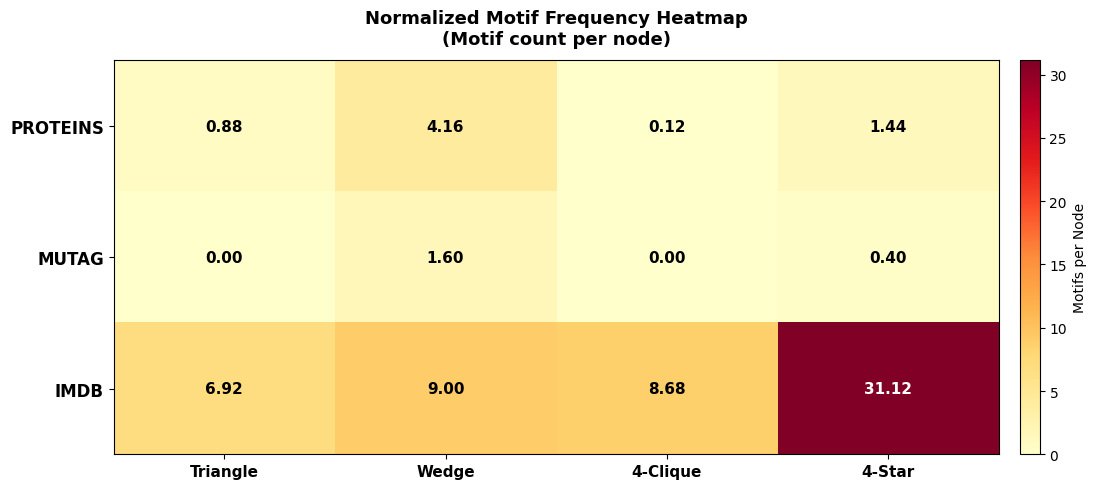

In [ ]:
# 2. 正規化熱力圖 - 顯示 Motif 的相對頻率（每個節點的平均 motif 數）
fig, ax = plt.subplots(figsize=(12, 5))

network_names = ['PROTEINS', 'MUTAG', 'IMDB']
all_motif_types = ['Triangle', 'Wedge', '4-Clique', '4-Star']

# 準備數據矩陣（正規化：除以節點數）
data_matrix = []
for network in network_names:
    counts = [results[network][motif] for motif in all_motif_types]
    num_nodes = graphs[network].number_of_nodes()
    # 計算每個節點的平均 motif 數量
    normalized_counts = [c / num_nodes for c in counts]
    data_matrix.append(normalized_counts)

data_matrix = np.array(data_matrix)

# 繪製熱力圖
# 在名為 ax 的這個繪圖區域上，繪製一張熱圖。YlOrRd (Yellow-Orange-Red)
# 'auto' 會調整圖像的寬高比以適應繪圖區域 ax 的大小。顏色映射的最小值為 0。
im = ax.imshow(data_matrix, cmap='YlOrRd', aspect='auto', vmin=0)

# 設置刻度標籤
ax.set_xticks(np.arange(len(all_motif_types)))
ax.set_yticks(np.arange(len(network_names)))
ax.set_xticklabels(all_motif_types, fontsize=11, fontweight='bold')
ax.set_yticklabels(network_names, fontsize=12, fontweight='bold')

# 在每個格子中顯示數值
for i in range(len(network_names)):
    for j in range(len(all_motif_types)):
        value = data_matrix[i, j]
        text = ax.text(j, i, f'{value:.2f}',
                      ha="center", va="center",
                      color="black" if value < data_matrix.max()/2 else "white",
                      fontsize=11, fontweight='bold')

ax.set_title("Normalized Motif Frequency Heatmap\n(Motif count per node)",
             fontsize=13, fontweight='bold', pad=12)

# 加入顏色條
cbar = fig.colorbar(im, ax=ax, label='Motifs per Node', pad=0.02)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

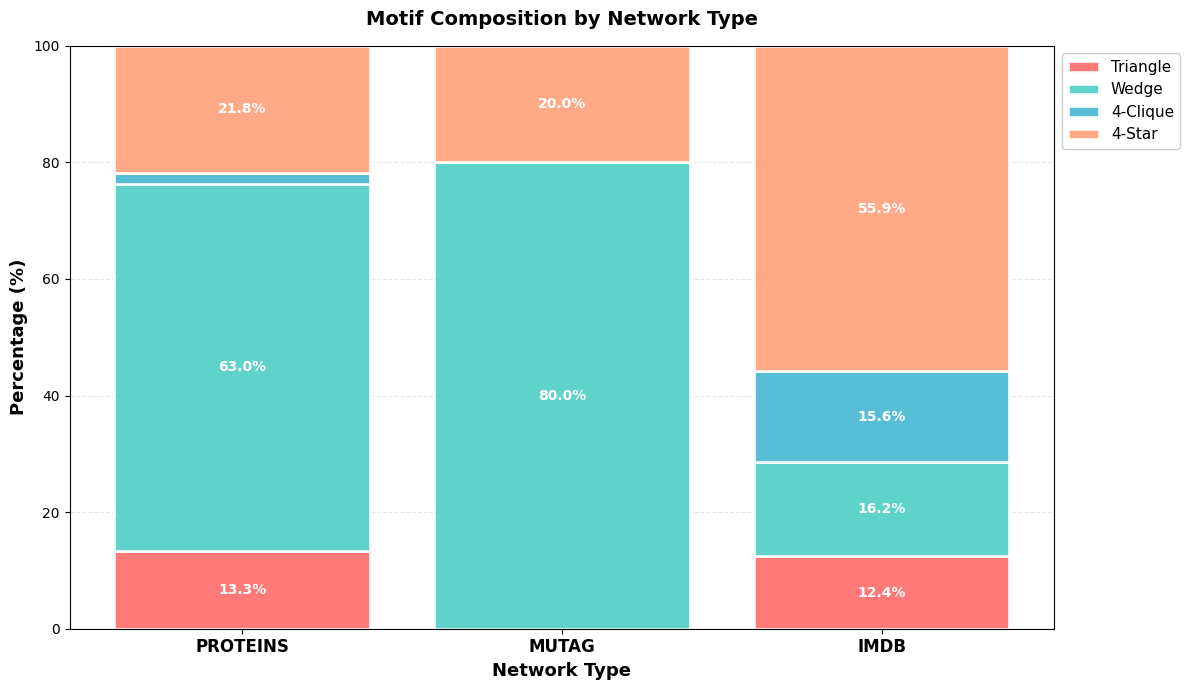

In [ ]:
# 3. 堆疊柱狀圖 - 顯示 Motif 組成比例
fig, ax = plt.subplots(figsize=(12, 7))

network_names = ['PROTEINS', 'MUTAG', 'IMDB']
all_motif_types = ['Triangle', 'Wedge', '4-Clique', '4-Star']

# 準備數據
data_dict = {motif: [] for motif in all_motif_types}
for network in network_names:
    for motif in all_motif_types:
        data_dict[motif].append(results[network][motif])

# 計算每個網路的總 motif 數
totals = [sum(results[network][motif] for motif in all_motif_types) for network in network_names]

# 計算百分比
percentages = {motif: [] for motif in all_motif_types}
for i, network in enumerate(network_names):
    if totals[i] > 0:
        for motif in all_motif_types:
            percentages[motif].append((results[network][motif] / totals[i]) * 100)
    else:
        for motif in all_motif_types:
            percentages[motif].append(0)

# 繪製堆疊柱狀圖
x_pos = np.arange(len(network_names))
bottom = np.zeros(len(network_names))

colors_motif = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#95E1D3']

for i, motif in enumerate(all_motif_types):
    bars = ax.bar(x_pos, percentages[motif], bottom=bottom, label=motif,
                  color=colors_motif[i], alpha=0.9, edgecolor='white', linewidth=2)

    # 在每個區塊中間顯示百分比
    for j, val in enumerate(percentages[motif]):
        if val > 3:  # 只顯示大於3%的標籤
            ax.text(j, bottom[j] + val/2, f'{val:.1f}%',
                   ha='center', va='center', fontweight='bold',
                   fontsize=10, color='white')

    bottom += percentages[motif]

ax.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold')
ax.set_xlabel('Network Type', fontsize=13, fontweight='bold')
ax.set_title('Motif Composition by Network Type',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(network_names, fontsize=12, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11, framealpha=0.95)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

## 5. Motif 結構示意圖

各種 motif 的拓撲結構

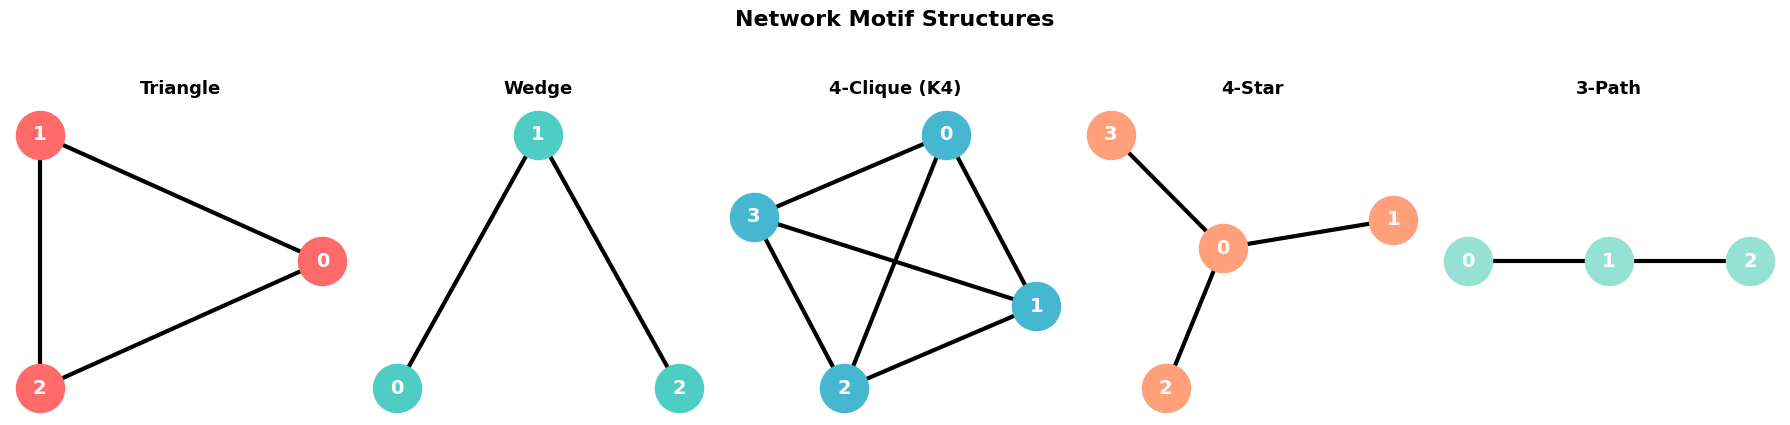

In [ ]:
# 繪製不同 motif 的示意圖
# 設置畫布與全局樣式
# 創建包含 1 行、5 列子圖的畫布和一個包含這 5 個繪圖區域的陣列。
fig, axes = plt.subplots(1, 5, figsize=(18, 4))
# 標題
fig.suptitle('Network Motif Structures', fontsize=16, fontweight='bold', y=1.05)

# 提供節點顏色的視覺化配置
motif_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#95E1D3']
node_size = 1200
font_size = 14

# 1. Triangle
# 目標畫布，五個子圖區域 (axes) 中的第一個區域 (索引0) 。
ax = axes[0]
# 初始化一個空的、無向的 NetworkX 圖形物件
G_tri = nx.Graph()
# 添加了三條邊，形成三角形 (3-Clique) 結構。
G_tri.add_edges_from([(0, 1), (1, 2), (2, 0)])
# 計算坐標，將它們均勻分佈在一個圓周上。
pos = nx.circular_layout(G_tri)
# 接受圖形結構 (G_tri) 和節點位置 (pos) 作為必要輸入，指定輸出、顯示標籤、節點顏色、節點大小、標籤文字顏色、邊緣樣式。
nx.draw(G_tri, pos, ax=ax, with_labels=True, node_color=motif_colors[0],
        node_size=node_size, font_size=font_size, font_weight='bold',
        font_color='white', width=3, edge_color='black')
# 子圖標題
ax.set_title('Triangle', fontsize=13, fontweight='bold', pad=10)

# 2. Wedge
ax = axes[1]
G_wedge = nx.Graph()
# 添加了兩條邊，形成Wedge結構。
G_wedge.add_edges_from([(0, 1), (1, 2)])
# 手動指定每個節點的 (x, y) 坐標
pos = {0: (-1, 0), 1: (0, 1), 2: (1, 0)}
nx.draw(G_wedge, pos, ax=ax, with_labels=True, node_color=motif_colors[1],
        node_size=node_size, font_size=font_size, font_weight='bold',
        font_color='white', width=3, edge_color='black')
ax.set_title('Wedge', fontsize=13, fontweight='bold', pad=10)

# 3. 4-Clique
ax = axes[2]
# 生成包含 4 個節點的完全圖
G_4clique = nx.complete_graph(4)
# 基於彈簧模型的演算法，它會嘗試將連接的節點拉近，不連接的節點推遠。
pos = nx.spring_layout(G_4clique, seed=42)
nx.draw(G_4clique, pos, ax=ax, with_labels=True, node_color=motif_colors[2],
        node_size=node_size, font_size=font_size, font_weight='bold',
        font_color='white', width=3, edge_color='black')
ax.set_title('4-Clique (K4)', fontsize=13, fontweight='bold', pad=10)

# 4. 4-Star
ax = axes[3]
# 生成一個包含 4 個節點的星型圖（中心點連接 3 個葉節點）
G_star = nx.star_graph(3)
# 基於彈簧模型的演算法，它會嘗試將連接的節點拉近，不連接的節點推遠。
pos = nx.spring_layout(G_star, seed=42)
nx.draw(G_star, pos, ax=ax, with_labels=True, node_color=motif_colors[3],
        node_size=node_size, font_size=font_size, font_weight='bold',
        font_color='white', width=3, edge_color='black')
ax.set_title('4-Star', fontsize=13, fontweight='bold', pad=10)

# 5. 3-Path
ax = axes[4]
G_path = nx.path_graph(3)
# 手動指定每個節點的 (x, y) 坐標
pos = {0: (0, 0), 1: (1, 0), 2: (2, 0)}
nx.draw(G_path, pos, ax=ax, with_labels=True, node_color=motif_colors[4],
        node_size=node_size, font_size=font_size, font_weight='bold',
        font_color='white', width=3, edge_color='black')
ax.set_title('3-Path', fontsize=13, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

## 6. 作業：看圖說故事

### 📊 請根據上面的圖表（熱力圖與堆疊柱狀圖），簡單描述你的觀察：

#### 1. 從**堆疊柱狀圖**中，你觀察到什麼？
**提示：每個網路中，哪種 motif 占的比例最大？三種網路的組成有何不同？**

從熱力圖與堆疊柱狀圖中，我們能看出以下數點:
- IMDB 網路在所有四種 Motif 上的頻率都遠高於其他兩者，顯示出此複雜網路的極端稠密性 (High Density)。
- 星型結構(4-Star)是出現頻率最高、占比最大的，其次是楔形結構(Wedge)，其中星行結構在IMDB數據集上的 4-Star 數量達到驚人的 31.12，是 PROTEINS (1.44) 的 20 倍以上，驗證出社交網路具備**高度中心化**的特徵。
- 此外IMDB數據集上，在 Triangle (6.92) 和 4-Clique (8.68) 上的高頻率，反映社交網路中普遍存在**社群結構**的現象。
- 在生物蛋白質網路 (PROTEINS) 上，表現出中等複雜的構造，PROTEINS 的 Wedge 數量最高 (4.16)，遠高於其 Triangle (0.88) 和 4-Clique (0.12) 的數量。
- 在化學分子網路 (MUTAG) 的極致稀疏性上，僅有極低的 Motif 數量，甚至在 Triangle (0.00) 和 4-Clique (0.00) 上的頻率為零，表現出它幾乎不包含更高階的 Motif 結構，較缺乏像社交網路那樣複雜的、多方連接的社群。


---

#### 2. 綜合來看，三種網路類型的差異
**簡單描述：PROTEINS、MUTAG、IMDB 這三種網路在 motif 分布上有什麼明顯的不同？**

綜合來看，三種網路類型的差異，我們能看出:
- 綜觀來看，藉由此次三個資料集的邊數可看出，MUTAG相對稀疏，PROTEINS中等稠密，IMDB是這三組最稠密的。化學分子的結構最不複雜，生物蛋白質次之，IMDB 電影評論情感分析資料集，涵蓋許多社交網路的訊息，是三者當中最複雜的，因此也具有最多的Motif結構數量。
- PROTEINS跟MUTAG都是Wedge結構最多；而IMDB是4-Star最多，Wedge結構次之。而三個數據集都是Triangle結構跟4-Clique結構最好，在MUTAG甚至是0，在此次的規模分布完全沒有這樣的結構出現。


---

### 💡 提示：
- 堆疊柱狀圖：顯示各 motif 在網路中的組成比例（百分比）
- 不需要深入解釋原因，只需描述你從圖表中看到的現象即可